##  [quiz] 2021년 11월 1일~ 2022년 1월 27일 코로나 확진자를 학습하고 이후 확진자수 예측하라

In [ ]:
#3일 동안의 확진자 수 추이를 보고 다음 날의 확진자 수를 예측
#따라서 인공지능은 3일 동안의 확진자 수를 보고 다음 날의 확진자 수가 어떻게 되었는지 학습
#만약 100일 동안의 확진자 수가 있다면 가장 먼저 1, 2, 3일차의 확진자 수가 어떻게 변하였는지 살펴보고 4일차의 확진자 수를 학습한다
#그리고 2, 3, 4일차의 확진자 수가 어떻게 변하였는지 살펴보고 5일차의 확진자 수를 학습한다
#이러한 방식으로 계속 학습하여 97, 98, 99일차의 확진자 수로 100일차의 확진자 수를 학습한다
#연속된 데이터의 형태에서 그 패턴을 찾아내는 순환 신경망(RNN) 방식으로, RNN의 기본적인 형태를 설계하고 학습시켜 본다


# RNN-코로나19 확진자수 예측

#### 필요한 라이브러리 임포트

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



#### 코로나 데이터 가져오기

In [48]:
df = pd.read_csv('../data/covid_2021101_20220127.csv', usecols=[3], engine='python')
data = df.values
data = data.astype('float32')   # 정규화하기 위해
data

array([[366382.],
       [367970.],
       [370637.],
       [373119.],
       [375462.],
       [377708.],
       [379933.],
       [381687.],
       [383404.],
       [385829.],
       [388347.],
       [390715.],
       [393039.],
       [395457.],
       [397461.],
       [399583.],
       [402772.],
       [406064.],
       [409097.],
       [412302.],
       [415422.],
       [418249.],
       [420946.],
       [425059.],
       [428996.],
       [432892.],
       [436959.],
       [440884.],
       [444191.],
       [447222.],
       [452344.],
       [457607.],
       [462551.],
       [467903.],
       [473028.],
       [477352.],
       [482305.],
       [489478.],
       [496853.],
       [503601.],
       [510578.],
       [517259.],
       [523075.],
       [528642.],
       [536491.],
       [544110.],
       [551544.],
       [558854.],
       [565087.],
       [570403.],
       [575595.],
       [583047.],
       [589961.],
       [596194.],
       [602034.],
       [60

#### 데이터 정규화 및 분류하기

In [49]:
scaler = MinMaxScaler()
corona = scaler.fit_transform(data)
corona

array([[0.        ],
       [0.0038628 ],
       [0.01035023],
       [0.01638758],
       [0.02208692],
       [0.02755022],
       [0.0329625 ],
       [0.03722906],
       [0.04140562],
       [0.04730433],
       [0.05342931],
       [0.05918944],
       [0.06484252],
       [0.07072425],
       [0.0755989 ],
       [0.0807606 ],
       [0.08851779],
       [0.09652549],
       [0.10390317],
       [0.11169922],
       [0.11928856],
       [0.12616515],
       [0.1327256 ],
       [0.14273036],
       [0.15230703],
       [0.16178393],
       [0.17167675],
       [0.18122423],
       [0.18926847],
       [0.1966412 ],
       [0.20910037],
       [0.22190249],
       [0.23392868],
       [0.24694729],
       [0.25941372],
       [0.26993167],
       [0.2819798 ],
       [0.29942787],
       [0.31736743],
       [0.33378172],
       [0.35075307],
       [0.3670045 ],
       [0.3811518 ],
       [0.39469337],
       [0.41378582],
       [0.4323188 ],
       [0.4504019 ],
       [0.468

In [58]:
#### shuffle=False임을 유의할 것(sequential 데이터이므로 shuffle해서는 안됨)
train, test = train_test_split(corona, test_size=0.2, shuffle=False)
train.shape, test.shape

((70, 1), (18, 1))

#### 데이터 형태 변경하기

In [62]:
def create_dataset(dataset, look_back):
    x_data = []
    y_data = []
    for i in range(len(dataset) - look_back):
        data = dataset[i:(i+look_back), 0]
        x_data.append(data)
        y_data.append(dataset[i + look_back, 0])

    return np.array (x_data), np.array(y_data)

In [67]:
look_back = 3
x_train, y_train = create_dataset(train, look_back)
x_train.shape, y_train.shape

((67, 3), (67,))

In [68]:
x_test, y_test = create_dataset(test, look_back)
x_test.shape, y_test.shape

((15, 3), (15,))

In [69]:
# 인공지능 모델의 입력 형태로 데이터 구조 변환
x_train = x_train[:, np.newaxis]
x_test = x_test[:, np.newaxis]
x_train.shape, x_test.shape

((67, 1, 3), (15, 1, 3))

In [70]:
x_train[0]

array([[0.        , 0.0038628 , 0.01035023]], dtype=float32)

### 인공지능 모델 만들기

In [71]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(1, 3)))     # input_shape(batch, timestep, feature) => batch(생략), timestep = 1, feature = 3
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics='mae', optimizer='adam')
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-27 17:47:48.446033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-27 17:47:48.447563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3)                 21        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


#### 모델 학습

In [72]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=3, verbose=2)

Epoch 1/100


2023-02-27 17:48:56.568887: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-27 17:48:57.104485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 - 2s - loss: 0.6002 - mae: 0.6362 - 2s/epoch - 89ms/step
Epoch 2/100
23/23 - 0s - loss: 0.4692 - mae: 0.5463 - 174ms/epoch - 8ms/step
Epoch 3/100
23/23 - 0s - loss: 0.3664 - mae: 0.4738 - 176ms/epoch - 8ms/step
Epoch 4/100
23/23 - 0s - loss: 0.2820 - mae: 0.4128 - 176ms/epoch - 8ms/step
Epoch 5/100
23/23 - 0s - loss: 0.2226 - mae: 0.3694 - 172ms/epoch - 7ms/step
Epoch 6/100
23/23 - 0s - loss: 0.1754 - mae: 0.3333 - 170ms/epoch - 7ms/step
Epoch 7/100
23/23 - 0s - loss: 0.1397 - mae: 0.3013 - 170ms/epoch - 7ms/step
Epoch 8/100
23/23 - 0s - loss: 0.1139 - mae: 0.2806 - 175ms/epoch - 8ms/step
Epoch 9/100
23/23 - 0s - loss: 0.0958 - mae: 0.2624 - 185ms/epoch - 8ms/step
Epoch 10/100
23/23 - 0s - loss: 0.0826 - mae: 0.2486 - 178ms/epoch - 8ms/step
Epoch 11/100
23/23 - 0s - loss: 0.0727 - mae: 0.2371 - 172ms/epoch - 7ms/step
Epoch 12/100
23/23 - 0s - loss: 0.0657 - mae: 0.2275 - 171ms/epoch - 7ms/step
Epoch 13/100
23/23 - 0s - loss: 0.0607 - mae: 0.2214 - 175ms/epoch - 8ms/step
Epoch 14/

#### 결과 시각화

In [74]:
df = pd.DataFrame(hist.history)
df

,loss,mae
0,0.600199,0.636236
1,0.469154,0.546287
2,0.366442,0.473762
3,0.281969,0.412809
4,0.222620,0.369438
...,...,...
95,0.000018,0.003377
96,0.000018,0.003378
97,0.000018,0.003375
98,0.000018,0.003382


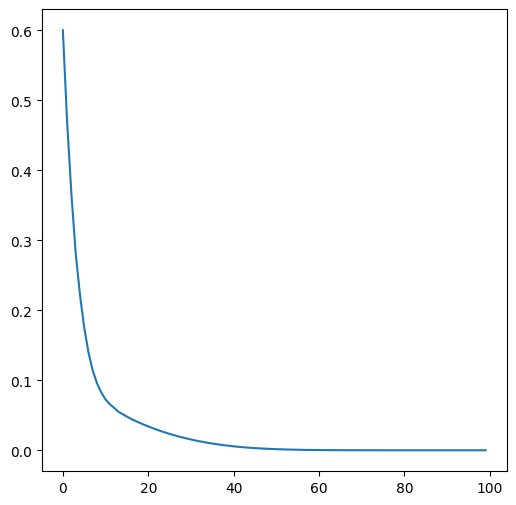

In [75]:
plt.figure(figsize=(6,6))
plt.plot(df.index, df.loss)

In [76]:
model.predict(x_test)

1/1 [==============================] - 0s 343ms/step


2023-02-27 17:52:54.727077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.7400798 ],
       [0.744212  ],
       [0.75212973],
       [0.7588086 ],
       [0.7663866 ],
       [0.77370477],
       [0.7808937 ],
       [0.7877067 ],
       [0.7930561 ],
       [0.8015021 ],
       [0.8115165 ],
       [0.82164323],
       [0.83127546],
       [0.8425454 ],
       [0.8536698 ]], dtype=float32)

In [ ]:
# 인버스 값 만들기 
# 숫자로 변환해야함.
inverse.transform